## Analysis on RR Lyrae stars in the PAL5 globular cluster

This notebook serves as a preliminary final routine of performing both aperture and PSF photometry on the Palomar 5 globular cluster using a program method similar to those outlined in DAOPhot (http://www.astro.wisc.edu/sirtf/daophot2.pdf). The aim is to obtain apparent magnitudes of the stars within the cluster and begin analysing them.

The stars found will be compared to a list of known RR Lyrae stars, obtained from Christine Clement's catalogue (http://www.astro.utoronto.ca/~cclement/index.html) and attempts made to find new ones using variability indices (as yet unsuccessful therefore temporarily omitted from this version). Once the stars found, light curves will be plotted by calculating their phase and folding if necessary, before processing them through some GLOESS code to obtain good curve fits. Periods from the catalogue will be used at first however it may prove necessary to calculate our own periods either by eye or by using a periodogram, the light curves will need to be redrawn in this case. 

Once the light curves have been obtained and accurate periods, then it is time to plot a PL relation: apparent magnitude vs log(period), using Neeley et al. 2019. A fit will be found for our points in order to calculate the distance to the stars.

General outline:

1) list of imports

2) potential user defined functions used throughout: i.e. aperture phot, ePSF routines, coordinate matching & transforms

3) init: file paths, channel information, parameters and models to be used in ePSF routines

4) master source list: creation of a master star list :: -ePSF for master image; -generate source list; -perform PSF on it and convert x, y into ra, dec [decimal]; -show list; -save for 3p6um and 4p5um filters

5) ePSF for photometry: build ePSF model again for using master or epoch 1 :: -use master epoch with options for any other epoch if desired (not recommended); -standard ePSF routine

6) Photometry: perform aperture and PSF photometry :: -Aper and PSF loop; -ignore aa code; -PSF using PSF sources NOT master; -obtain mags and errors; -manual errors?; -convert to ra, dec; -compare against master source list; -return main_table for both 3p6um and 4p5um filters. Ensure the previous code need not be run everytime for the next points:

7) Identify known RRLs :: -clean up code, esp. coord parts

8) Periods: obtain periods of each star :: -calculate the periods of each star using a periodogram, perhaps skip to 9 and return

9) Light curves: obtain light curves :: -plot light curves in phase-time; -perform GLOESS analysis; -fold if necessary

10) PL relation: fit PL relation :: -hold b constant, leave a to vary; -fit to data using a function and curve_fit(); -obtain distances (see equations)

11) Analysis: variability indices, metallicity if time permits and perform above routine on another globular cluster

In [1]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

#### Defined functions used throughout the notebook

In [ ]:
# user defined function here #

#### Initialisation and options

In [2]:
## INPUT DATA PATHS ##

epoch_path = 'PAL5_data/*/'
master_path = 'PAL5_data/PAL5/'
general_path = 'PAL5_data/'

## CHANNEL ##

channel = '3p6um'

if channel == '3p6um':
    aper_corr = 1.1233           # aperture correction for 337 (6,6,14) apertures in channel 1, c.f IRAC handbook §4.10
    ap_err    = aper_corr * 0.02 # uncertainty to ~2% as per IRAC handbook
    zmag      = 18.80            # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err  = 0.02             # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err    = aper_corr * 0.02
    zmag      = 18.32
    zmag_err  = 0.02
else:
    raise ValueError('Incorrect channel input: only values 3p6um or 4p5um permitted.')
    
## PARAMETERS AND OPTIONS ##

fwhm = 5.
sigma = 5.
sigma_epsf = 50.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = +0.5
sharphi = 0.9
sharphi_model = 0.7

phot_method = 'psf'     # SELECT PHOTOMETRY METHOD: 'aperture' or 'psf'
model_to_use = 'master' # SPECIFY DATA TO USE IN ePSF MODEL

#### Master star list

FITS file information:
FILE = PAL5_data/PAL5/PAL5_3p6um.fits

Number of ePSF sources found = 26

Number of refined ePSF sources = 21



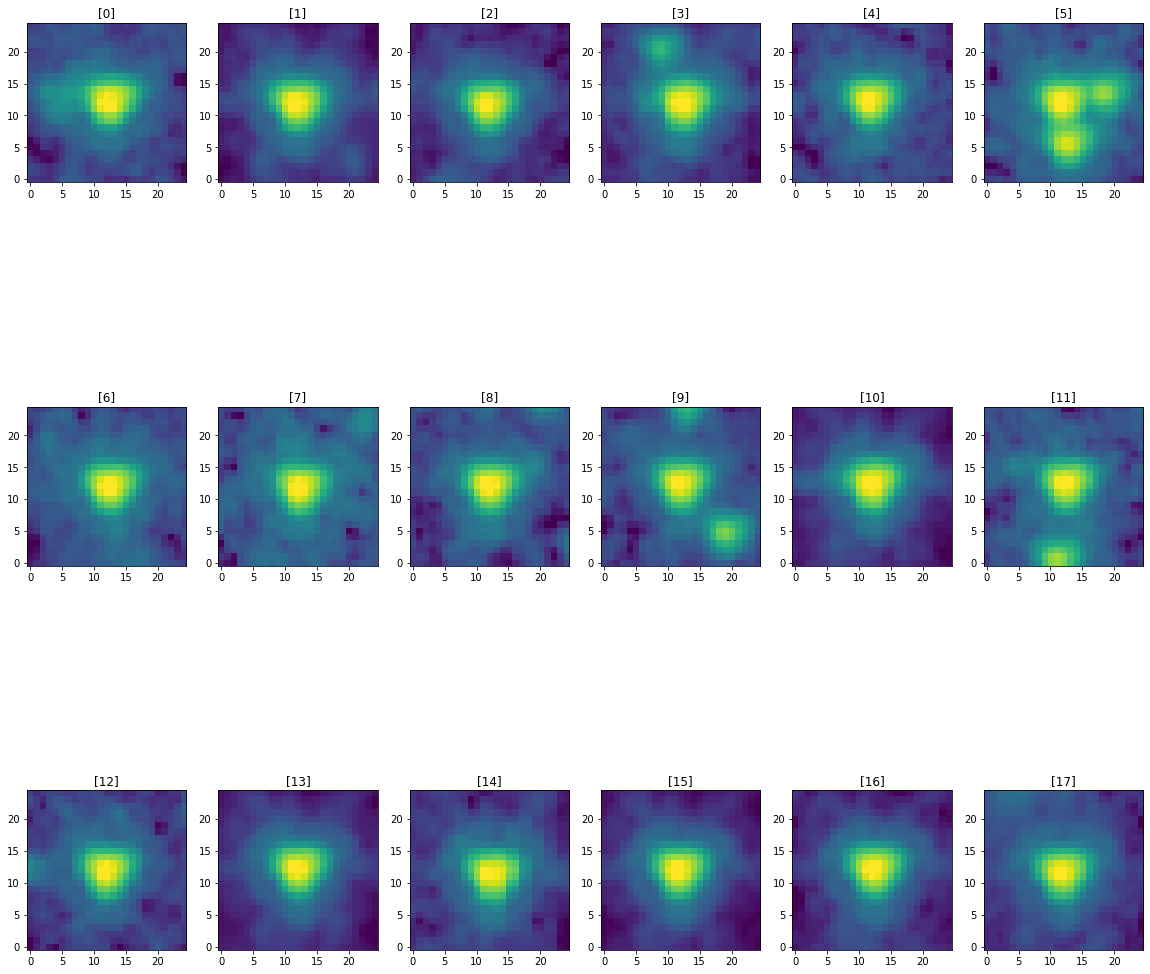

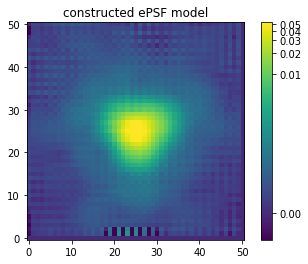

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
11


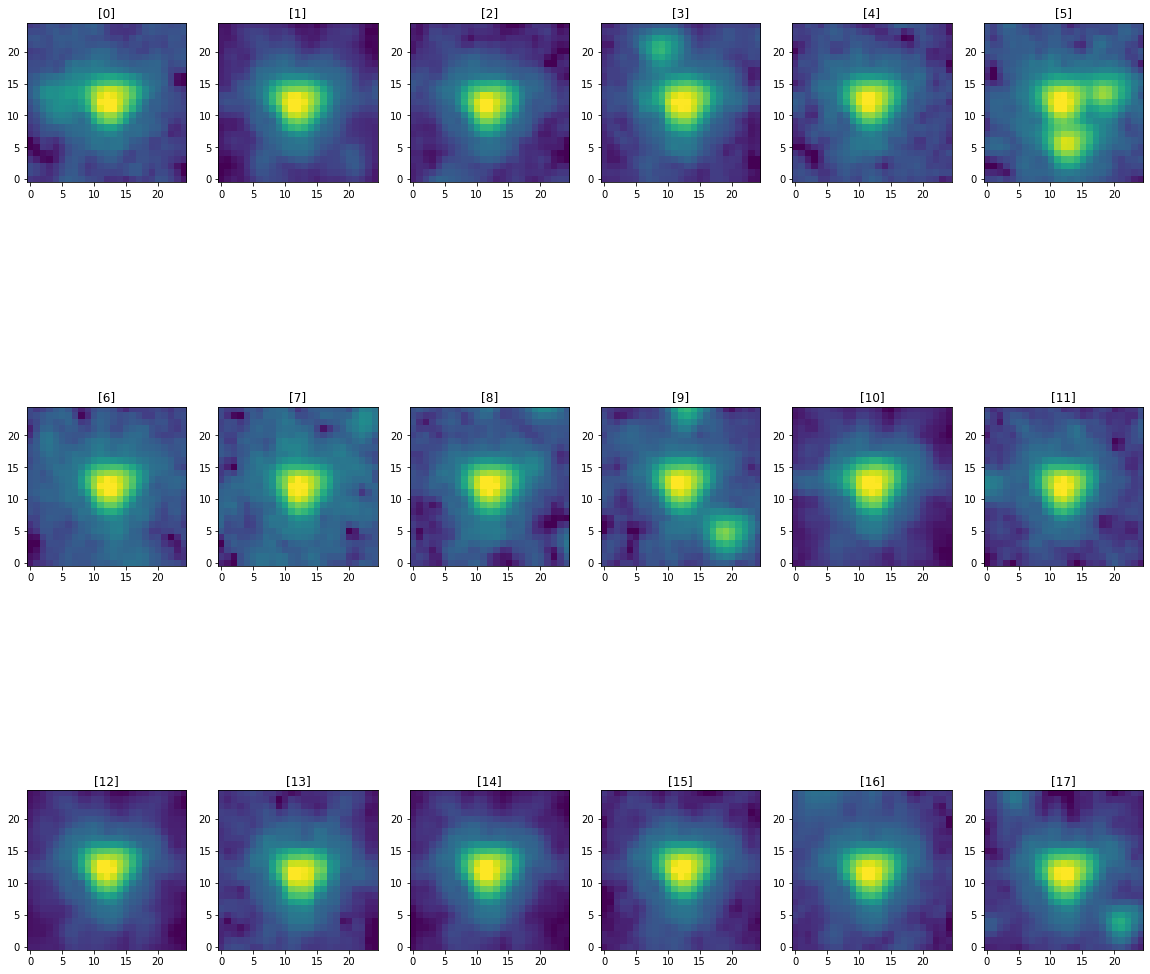

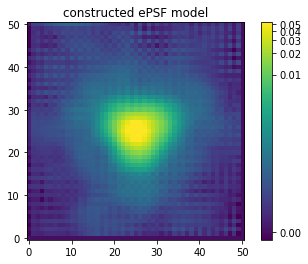

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



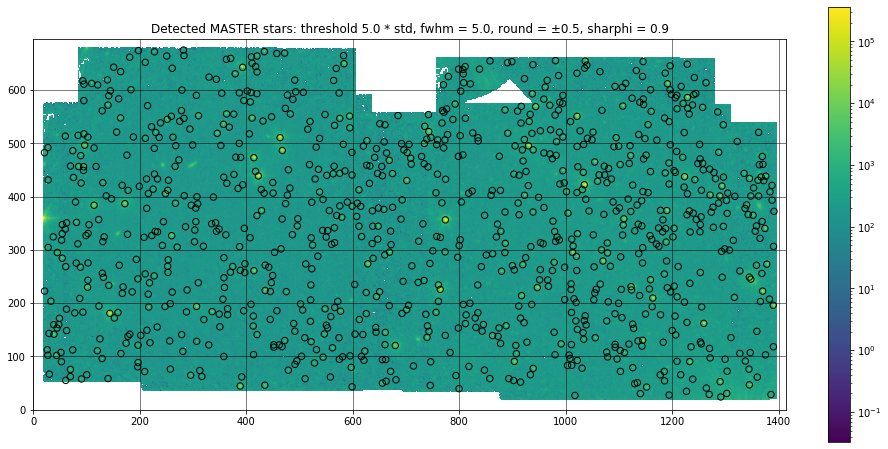

Number of MASTER stars detected = 995



Number of MASTER stars found from PSF = 1097



idx,master_id,x_0,y_0,ra,dec
0,0,1291.2929189184636,23.77539584300217,229.06323548078797,-0.16015538084946376
1,1,1269.5063258483376,28.576868985369124,229.0630315162843,-0.15644268282020193
2,2,1302.5323577023107,30.41383225609205,229.06184132896902,-0.1618256156510142
3,3,1264.2161506278433,40.4727125768036,229.0612170509874,-0.15525266063353485
4,4,1017.3141619201139,26.634326163017445,229.07013218013552,-0.11501273812811508
5,5,1194.222098350761,27.325663287025055,229.0652616258944,-0.14409310419192672
6,6,1385.565085865048,28.366620747972743,229.05994541672302,-0.17553839027507637
7,7,1140.2739672278392,29.994285687889022,229.0662732722692,-0.1351476171842811
8,8,1152.0517082774918,42.328688459734956,229.06392773476134,-0.1367532412693178
9,9,1129.5421224473064,48.674351148967304,229.06348921167694,-0.13288009487872435


In [6]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as header_list:
    master_hdr = header_list[0].header
    counts = master_hdr['EXPTIME'] / master_hdr['FLUXCONV']
    image_data = fits.getdata(master_file, ext = 0)
    master_data = image_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(master_data, sigma = sigma_epsf) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(master_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (master_data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (master_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = master_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

    
## SOURCE DETECTION ##

mean_m, median_m, std_m = sigma_clipped_stats(master_data, sigma = sigma)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_m, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
master_sources = master_daofind(master_data)

# PLOT INITIAL DETECTED SOURCES
master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = r_ap)

plt.imshow(master_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma, fwhm, roundhi, sharphi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))

## RENAME STAR LIST HEADERS ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
#master_sources['id'].name = 'master_id'

## PSF ROUTINE ON MASTER LIST ##

daogroup = DAOGroup(crit_separation = sigma * fwhm)

data_psf_master = np.nan_to_num(master_data, nan = 1**-7)

#master_psf = np.transpose((master_sources['x_0'], master_sources['y_0']))
epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_master = Table(names = ['x_0', 'y_0'], data = [master_sources['x_0'], master_sources['y_0']])

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = MMMBackground(),
                                                    psf_model = epsf,
                                                    fitter = LevMarLSQFitter(),
                                                    niters = 2,
                                                    aperture_radius = r_ap,
                                                    fitshape = (11, 11))

master_phot = PSF_photometry(image = data_psf_master, init_guesses = pos_master)
residual_image = PSF_photometry.get_residual_image()

print('Number of MASTER stars found from PSF = {0}\n'.format(len(master_phot)))

## COORDINATE CONVERSION ##

master_list = copy.copy(master_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i
    
del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

#master_list['master_id'] = np.arange(len(master_list))

w = wcs.WCS(master_hdr)
coord = np.transpose((master_list['x_0'], master_list['y_0']))
world = w.wcs_pix2world(coord, 0)
ra_m, dec_m = world[:, 0], world[:, 1]
c_m = SkyCoord(ra_m, dec_m, frame = 'icrs', unit = 'deg')

master_list['ra'] = ra_m
master_list['dec'] = dec_m

## EXPORT AND SAVE FILE -- SHOW IN NOTEBOOK ##

master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_master_list_{0}.txt'.format(channel), format = 'csv', overwrite = True)

master_list.show_in_notebook()

#### Building new ePSF for photometry

In [ ]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as header_list:
    master_hdr = header_list[0].header
    counts = master_hdr['EXPTIME'] / master_hdr['FLUXCONV']
    image_data = fits.getdata(master_file, ext = 0)
    master_data = image_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(master_data, sigma = sigma_epsf) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(master_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (master_data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (master_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = master_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

#### Performing PSF photometry on all epochs

In [7]:
## PHOTOMETRY ON EPOCHS ##

## INITIALISE MAIN TABLE ##

main_table = copy.copy(master_list)

## STORE EPOCH TIMES AS MODIFIED JULIAN DATE [MJD] ## #refine?

epoch_time = []

## EPOCH LOOP COUNTER ##

epoch = 0

## PHOTOMETRY LOOP ##
for file in glob.glob(epoch_path+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(epoch_path+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        epoch_hdr = header_list[0].header
        counts = epoch_hdr['EXPTIME'] / epoch_hdr['FLUXCONV']
        time = Time(epoch_hdr['DATE_OBS'])
        
        image_data = fits.getdata(file, ext = 0)
        epoch_data = image_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\n\n'.format(file, time))
    
    ## EXTRACT TIME FROM EPOCH ##
    
    epoch_time.append(Time(epoch_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTION ##
    corr_file = general_path+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    mean_psf, median_psf, std_psf = sigma_clipped_stats(epoch_data, sigma = sigma)

    ## APERTURE PHOTOMETRY LOOP ##
    if phot_method == 'aperture':
        raise ValueError('Incorrect photometry method input! Aperture photometry suspended.')
    
    elif (phot_method == 'psf' or phot_method == 'PSF'):
        ## SOURCE DETECTION ON IMAGE ## 
        psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_psf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
        psf_sources = psf_daofind(epoch_data)
        print('Number of inital stars detected = {0}\n'.format(len(psf_sources)))
        
        ## GROUP ## 
        psf_sources['xcentroid'].name = 'x_0'
        psf_sources['ycentroid'].name = 'y_0'
        
        daogroup = DAOGroup(crit_separation = sigma * fwhm)
        
        data_psf = np.nan_to_num(epoch_data, nan = 1**-7)
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])
        
        ## PERFORMING PSF PHOTOMETRY ##

        PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                            group_maker = daogroup,
                                                            bkg_estimator = MMMBackground(),
                                                            psf_model = epsf,
                                                            fitter = LevMarLSQFitter(),
                                                            niters = 2,
                                                            aperture_radius = r_ap,
                                                            fitshape = (11, 11))

        result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
        residual_image = PSF_photometry.get_residual_image()
        
        print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
        
        phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
        
        PSF_err = phot['flux_unc']
        PSF_flux = phot['flux_fit']
        
        ## APPARENT MAGNITUDES ##
    
        phot['apparent_mag'] = float('NaN')
        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
        
        ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
        phot['apparent_mag_unc'] = float('Nan')
        for i in range(0, len(phot)):
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
            
        ## CONVERT COORDINATES ##
        
        w = wcs.WCS(epoch_hdr)
        coord = np.transpose((phot['x_fit'], phot['y_fit']))
        world = w.wcs_pix2world(coord, 0)
    
        ra_e, dec_e = world[:, 0], world[:, 1]
        c_e = SkyCoord(ra_e, dec_e, frame = 'icrs', unit = 'deg')

        phot['ra'] = ra_e
        phot['dec'] = dec_e
        
        ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
        
        epoch_table = copy.copy(phot)
        # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
        del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
        epoch_mag = 'mag_e'+str(epoch)
        epoch_unc = 'unc_e'+str(epoch)
        #epoch_ra = 'ra_e'+str(epoch)
        #epoch_dec = 'dec_e'+str(epoch)
        # RENAME COLUMNS FOR EASE
        #epoch_table.rename_column('ra', epoch_ra)
        #epoch_table.rename_column('dec', epoch_dec)
        epoch_table.rename_column('apparent_mag', epoch_mag)
        epoch_table.rename_column('apparent_mag_unc', epoch_unc)
        epoch_table.rename_column('x_fit', 'xcenter')
        epoch_table.rename_column('y_fit', 'ycenter')
        
        ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##
        
    else:
        raise ValueError('Incorrect photometry method input! Input only value `psf`')
    
    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##
    
    temp_table = copy.copy(main_table)
    
    w = wcs.WCS(epoch_hdr)
    coord = np.transpose((epoch_table['xcenter'], epoch_table['ycenter']))
    world = w.wcs_pix2world(coord, 0)

    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    
    idx, d2d, d3d = c.match_to_catalog_sky(c_m)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    radius = 0.25 * u.arcsec
    selection = (d2d > radius)
    match_index = idx
    match_index[selection] = -99.
    matches = ((match_index >= 0))
    
    epoch_table = epoch_table[matches]
    temp_table = temp_table[match_index][matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = temp_table['master_id']
    
    epoch_table = Table(epoch_table, masked = True)
    #epoch_ra, epoch_dec,
    
    main_table = join(main_table, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_interim_phot_epoch{0}_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    
main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_main_phot_{0}.txt'.format(channel), format = 'csv', overwrite = True)
#main_table.show_in_notebook()

EPOCH NUMBER = 1

FITS file information:
FILE = PAL5_data\PAL5__e1\PAL5__e1_3p6um.fits
DATE = 2013-05-10T21:50:03.531




Number of inital stars detected = 763



Number of PSF stars found and analysed = 910

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1182.2691587688644 ...  229.0662637593638  -0.14256723377314234
  2        2  1335.720143020897 ...  229.0618888984609   -0.1677666576844223
  5        2 1325.4233008232586 ...  229.0620553171843  -0.16605466888799805
  6        2   1346.68596402586 ... 229.06106715258827  -0.16948310247064197
  9        2 1300.2369547517922 ... 229.06182515731362  -0.16176153571792268
 11        2 1323.7404837650017 ... 229.06069177344185  -0.16554448707544306
 21        2 1343.0230028569008 ... 229.05801424310192  -0.16835853242175516
 38        2 1342.0566835923876 ... 229.05589680822814   -0.1678445061855713
 39        2 1358.1588967509692 ...  229.0553115907226  -0.17046788088013468
 56        2 1342.2278965985688 ... 229.05322218434284  -0.16743035109258536
...      ..

Number of inital stars detected = 769



Number of PSF stars found and analysed = 909

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1143.0406079487218 ... 229.06741407395347  -0.13610904729529075
 10        1 1138.3435127601874 ... 229.06628378818826  -0.13512884532770075
 22        1   1150.14697405021 ... 229.06393787462753  -0.13673523548519564
 30        1  1127.897451801893 ... 229.06348175403753   -0.1329012980103931
 32        1 1133.0398253328622 ... 229.06303746608754  -0.13369659480508858
  2        2 1304.4601590437453 ...  229.0630563882371   -0.1626575273373985
  7        2 1288.3385445296367 ...  229.0631115895762  -0.15994324622287853
  9        2  1267.525752692554 ... 229.06300079128866  -0.15640906704271035
 13        2 1300.7852923152661 ... 229.06178351426067  -0.16182645451375405
 17        2 1287.8100262876533 ... 229.06048618717594  -0.15942023890188178
...      ..

Number of inital stars detected = 778



Number of PSF stars found and analysed = 925

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1130.2693479656143 ... 229.06778373993626  -0.13401077044615003
  2        1  1119.793559095858 ...   229.067497306874  -0.13219400058341715
  9        1 1138.0849429942987 ... 229.06629699387372  -0.13508590714908442
 16        1 1150.1339733783786 ...  229.0639443950709  -0.13673342976391645
 22        1  1127.747768171698 ... 229.06352958955392   -0.1328836081318992
 24        1 1132.9494213191713 ...  229.0630485689526  -0.13368297695554765
  3        2 1198.7198131040502 ... 229.06523355494676   -0.1451529780309224
  4        3 1255.7012631377313 ... 229.06329546853448  -0.15445874382536529
  5        3 1267.6772125449183 ... 229.06306196337945  -0.15644321415873477
  6        4  879.7915813850537 ...  229.0733871485326  -0.09262398643363072
...      ..

Number of inital stars detected = 767



Number of PSF stars found and analysed = 895

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1  1195.394669985951 ...  229.0658989179787  -0.14483558599731192
  7        1 1194.1449905547597 ... 229.06416639896992   -0.1443396661829222
 28        1 1183.5007036260029 ... 229.06116204952417  -0.14204783048691294
 48        1 1182.8978967172704 ...  229.0581946149478  -0.14145814111627547
 64        1  1188.222220177059 ... 229.05669917558558  -0.14211159467996043
  2        2 1275.7699286569268 ... 229.06362993420743  -0.15803849572871204
  4        2  1266.409662317724 ... 229.06300855425116  -0.15635532145865974
  3        3 1086.2135963358105 ...  229.0685905503571  -0.12683664355591096
  5        4  1300.342887929459 ...  229.0618445931514  -0.16189551603904243
  6        5 1055.9376628676084 ...  229.0681897075935  -0.12165691604484559
...      ..

Number of inital stars detected = 736



Number of PSF stars found and analysed = 893

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1355.0030874332106 ... 229.06142822124644  -0.17102440071025185
  7        1 1373.7286017263907 ... 229.05889570148517  -0.17377169609802462
  8        1 1352.0204372216883 ... 229.05915836021305  -0.17014834824849046
 17        1 1342.6506089991321 ...  229.0581127009388  -0.16839431370261018
 37        1 1356.9450366506624 ... 229.05510741573354   -0.1703156737969655
 52        1  1349.251023846671 ... 229.05331707696058  -0.16872253828748357
 54        1 1341.6476941580377 ...  229.0532395627018  -0.16742565015876107
 69        1 1334.8575712761617 ...  229.0508815291958  -0.16589206636259649
 84        1 1324.8497761143408 ... 229.04871942125266  -0.16384716394674842
  2        2 1014.7727073154481 ... 229.07010738222752  -0.11498418952147038
...      ..

Number of inital stars detected = 739



Number of PSF stars found and analysed = 865

prelim epoch_table
 id group_id      xcenter       ...         ra                 dec         
--- -------- ------------------ ... ------------------ --------------------
  1        1 1026.4325376883728 ... 229.06942139232967 -0.11680184145041946
  2        2 1267.3933866624116 ... 229.06302736479086 -0.15645054337128708
  3        3 1138.1840820994687 ... 229.06626867864603  -0.1351592698836609
 10        3 1149.9732466988676 ... 229.06391749534305  -0.1367656487756198
  4        4 1300.3706607890526 ...  229.0618049763401  -0.1618199365831226
  6        4 1310.6529579915064 ...  229.0612290614822 -0.16346224663852885
  9        4 1309.0705944058593 ...  229.0600022979061  -0.1629943201523325
 22        4  1288.128928316752 ... 229.05850351210782  -0.1592123973817345
 47        4 1301.1416697464447 ...  229.0549488758701 -0.16082854201718086
  5        5  956.7258322921341 ... 229.07071896471294 -0.10524167308709555
...      ...           

Number of inital stars detected = 804



Number of PSF stars found and analysed = 964

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1304.3555191833918 ... 229.06329478297812  -0.16269403055124987
  2        1 1300.9231418025008 ...  229.0630045800693   -0.1620670122998458
  3        2  985.4389412660558 ...   229.071299376203  -0.11014343760452745
  4        3 1239.1268453695939 ... 229.06449651842397  -0.15187467299729335
 10        3 1225.8422551274175 ... 229.06307077544636  -0.14939848583950632
  5        4 1374.4526294998273 ... 229.06083288739597  -0.17412982806361932
 11        4 1374.7882983871489 ... 229.05865062802133  -0.17383027605436127
  6        5 1015.7222468491811 ... 229.07030820493304  -0.11509575746342977
  7        6 1191.4555573737175 ...  229.0655069683207  -0.14398909960089487
  8        7  918.5750693185291 ... 229.07250715824958  -0.09904889714186112
...      ..

Number of inital stars detected = 745



Number of PSF stars found and analysed = 853

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1151.3579477955802 ... 229.06709624544715   -0.1374725693085182
  9        1 1138.5765883425688 ... 229.06626140471963  -0.13517824623480393
 15        1  1123.276784368428 ... 229.06516866955997  -0.13241663528177788
 17        1 1150.2216495410134 ... 229.06392767817454  -0.13676457333848555
 25        1 1127.5217131254803 ... 229.06352503661964  -0.13286573626140466
 28        1 1132.6428679232995 ... 229.06305998573794  -0.13365477629132402
  2        2  1298.350952803261 ... 229.06294009052445   -0.1616177268023184
  5        2 1289.5296258932333 ...  229.0630943727617  -0.16015323506814236
  7        2 1268.0035197776308 ...   229.062998358857  -0.15650256827530895
 10        2 1311.2483966910613 ... 229.06131842909738  -0.16353152171049878
...      ..

Number of inital stars detected = 708



Number of PSF stars found and analysed = 805

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec          
--- -------- ------------------ ... ------------------ ----------------------
  1        1 1054.7886547107632 ... 229.06984078308628   -0.12140237128148174
  2        2 1135.6865428940748 ... 229.06768714051802   -0.13471249357604337
  6        2 1122.9373919970037 ... 229.06729212835373   -0.13249554234157426
  7        2  1139.743483022455 ...  229.0662647497793   -0.13516640709176977
 19        2  1151.580030677693 ...  229.0639181598983    -0.1367837781902624
 24        2 1133.8214293241108 ... 229.06303843875756   -0.13364219285367057
  3        3 1347.2731368769867 ... 229.06168453173743   -0.16946468673592188
  5        3 1337.0717971948834 ...  229.0617194479792   -0.16774780999083416
 14        3 1352.9663013203897 ...  229.0592375564975    -0.1700284010901417
 22        3 1343.9975710641036 ...   229.058043984761   -0.16832004106512796

Number of inital stars detected = 763



Number of PSF stars found and analysed = 889

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1375.3958407376256 ... 229.06122185434097   -0.1740908389385454
  2        2  967.0118228713301 ... 229.07174025499853  -0.10684219126788282
 12        2  989.3577907262297 ...  229.0694272964571  -0.11024019276641714
  3        3 1291.0501147291304 ...  229.0633055210507    -0.160187245727772
  7        3 1269.1493307642374 ...  229.0630499234898  -0.15644793607906846
 11        3 1301.9159852236198 ... 229.06182008487764   -0.1617810488166198
  4        4   889.837499678805 ... 229.07341655574731  -0.09408337145179893
  5        5 1036.5067597536927 ... 229.06938527949902  -0.11819432334732968
  6        5 1027.3748805381933 ...  229.0694566064582  -0.11666400215781914
  8        6 1330.3600477599343 ... 229.06137963138272  -0.16651230266699735
...      ..

Number of inital stars detected = 776



Number of PSF stars found and analysed = 888

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1081.2101697737955 ... 229.06917043286603  -0.12566924487694217
  2        2 1375.5458796566047 ... 229.06121005880175  -0.17407604142660454
  8        2 1384.2359267868446 ...  229.0599090728732  -0.17533274134920124
 13        2 1347.2619790623444 ... 229.06019451277217  -0.16913635906216984
 14        2 1352.3375979700616 ... 229.05936096580854   -0.1698584423754513
 24        2  1362.911074684258 ...  229.0581851090648  -0.17145338097196147
 31        2 1344.7096380214712 ... 229.05802370312708   -0.1683541906290281
 32        2 1375.0604434422019 ...  229.0572114843659  -0.17334710941396098
 40        2 1386.6761379117652 ... 229.05612246503196  -0.17513206274280146
 55        2 1359.3742788849495 ... 229.05534014798312  -0.17039592177531518
...      ..

Number of inital stars detected = 753



Number of PSF stars found and analysed = 868

prelim epoch_table
 id group_id      xcenter       ...         ra                  dec         
--- -------- ------------------ ... ------------------ ---------------------
  1        1 1324.2008651065337 ...  229.0624524663298  -0.16555457054848166
  6        1 1302.9685818287087 ...  229.0618084582686  -0.16186609664344143
  2        2 1261.7845449485044 ...  229.0634654149974  -0.15518055989314505
  3        3  927.9495340651808 ... 229.07199756698913  -0.10019742093018415
 10        3  912.6747600372972 ... 229.07066538850626  -0.09740366835122032
  4        4   1058.40338357842 ... 229.06853398677274  -0.12166249626558713
  5        5 1140.5291986083355 ... 229.06627305326262  -0.13516260891949972
  9        5 1125.7687380995305 ...  229.0652139412505    -0.132499754215704
 13        5  1152.139987793664 ... 229.06391714749432  -0.13674263815468887
 21        5  1129.818015575019 ... 229.06346663315662    -0.132901414407955
...      ..